In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import random
import seaborn as sns
import hdbscan
from scipy.stats import ttest_ind

In [2]:
!pip install hdbscan numpy


### Read food crises data

In [102]:
# Read the data and perform preprocessing

df = pd.read_csv("data/filled_food_crisis_cleaned.csv") # Read data into 'df' dataframe
df = df.sort_values(by='year_month')

df

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date
0,South Sudan,74,Bor,32.00486,6.465644,2007_01,2007,1,2.0,NaN,...,0.048880,0,0,0.561363,14008.3300,7.961984,239344.00,11393.760,90.85030,2007-01-01
56,South Sudan,147,Fashoda,31.84424,9.980295,2007_01,2007,1,1.0,NaN,...,0.311445,0,0,0.501935,3609.4460,18.379110,40665.38,20706.260,83.44186,2007-01-01
55,South Sudan,96,Ezo,27.89410,5.460567,2007_01,2007,1,1.0,NaN,...,-0.706674,0,0,0.585888,8133.7660,12.966620,86867.96,18984.280,60.11828,2007-01-01
54,South Sudan,88,Budi,33.44930,4.357813,2007_01,2007,1,2.0,NaN,...,2.113159,0,0,0.636777,5807.7300,38.994520,103594.40,251978.200,76.38571,2007-01-01
53,South Sudan,81,Yei,30.34454,4.252148,2007_01,2007,1,1.0,NaN,...,1.305629,0,0,0.669709,6713.2510,16.303490,215686.20,75813.310,62.85185,2007-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12268,South Sudan,75,Jur River,28.02439,7.592506,2020_02,2020,2,2.0,0.0,...,-0.045015,3,1,85.878370,10091.0400,0.157174,149820.60,3157.810,85.95082,2020-02-01
12267,South Sudan,74,Bor,32.00486,6.465644,2020_02,2020,2,3.0,0.0,...,1.626268,2,0,74.827220,14008.3300,7.961984,285097.40,11393.760,90.85030,2020-02-01
12266,South Sudan,90,Juba,31.48342,4.717081,2020_02,2020,2,3.0,0.0,...,3.086076,8,3,99.231030,18447.0400,33.070410,532118.60,41151.600,77.65000,2020-02-01
12273,South Sudan,80,Ikotos,33.13061,4.027118,2020_02,2020,2,3.0,0.0,...,6.278818,0,0,67.437470,3562.8510,33.419380,489921.20,341473.800,70.00000,2020-02-01


In [4]:
len(df['district'].unique())

78

In [5]:
# Group by district and use backfill within each district for 'IPC' column
grouped = df.groupby('district')
df['ipc'] = grouped['ipc'].transform(lambda x: x.bfill())

In [6]:
# Export to CSV
#df.to_csv('data/filled_food_crisis_cleaned.csv', index=False)

### Read summary articles data

In [7]:
# Read news articles data
df_news = pd.read_csv("data/articles_summary_cleaned_standardized.csv") # Read data into 'df' dataframe
df_news = df_news.sort_values(by='date')
df_news.rename(columns={'location_new': 'district'}, inplace=True)
df_news.head(5)

,summary,date,location_article,lat,lng,district
35,The article discusses the finalization of the ...,2011-06-07,Khartoum,15.500654,32.559899,Khartoum
47,The article discusses the need for the interna...,2011-06-14,South Sudan,6.876992,31.306979,South Sudan
38,The article discusses the challenges faced by ...,2011-06-22,Khartoum,15.500654,32.559899,Khartoum
40,The article discusses the debate in South Suda...,2011-06-25,Juba,4.859363,31.571250,Juba
87,The article discusses the recognition of South...,2011-06-26,Juba,4.859363,31.571250,Juba


In [8]:
# Convert the 'date' column to datetime format
df_news['date'] = pd.to_datetime(df_news['date'])


In [9]:
df_news['year'] = df_news['date'].dt.year
df_news['month'] = df_news['date'].dt.month

In [10]:
# Define a list of conflict-related keywords
conflict_keywords = ['war', 'battle', 'fight', 'conflict', 'aggression', 'hostility','troop','rebel']

# Create a regex pattern
pattern = '|'.join(conflict_keywords)

# Check if summary contains any of the keywords and assign results to a new column
df_news['conflict_mentioned'] = df_news['summary'].str.contains(pattern, case=False, na=False).astype(int)
df_news.head(20)

,summary,date,location_article,lat,lng,district,year,month,conflict_mentioned
35,The article discusses the finalization of the ...,2011-06-07,Khartoum,15.500654,32.559899,Khartoum,2011,6,1
47,The article discusses the need for the interna...,2011-06-14,South Sudan,6.876992,31.306979,South Sudan,2011,6,0
38,The article discusses the challenges faced by ...,2011-06-22,Khartoum,15.500654,32.559899,Khartoum,2011,6,1
40,The article discusses the debate in South Suda...,2011-06-25,Juba,4.859363,31.571250,Juba,2011,6,0
87,The article discusses the recognition of South...,2011-06-26,Juba,4.859363,31.571250,Juba,2011,6,0
79,The article discusses the expectations of posi...,2011-06-27,Republic of South Sudan,6.876992,31.306979,South Sudan,2011,6,1
83,The article discusses Sudanese President Omar ...,2011-06-28,Juba,4.859363,31.571250,Juba,2011,6,1
53,The article discusses the challenge of disarmi...,2011-06-28,Nairobi,-1.292066,36.821946,Nairobi,2011,6,0
75,The article discusses the denial by GoSS of me...,2011-06-29,Juba,4.859363,31.571250,Juba,2011,6,0
34,The article discusses a partial agreement reac...,2011-06-29,Khartoum,15.500654,32.559899,Khartoum,2011,6,0


In [11]:
# Group by location_article and calculate the sum of conflict_mentioned
grouped_loc = df_news.groupby('location_article').agg({'conflict_mentioned': 'sum'}).reset_index()

grouped_loc.sort_values(by='conflict_mentioned', ascending=False)

,location_article,conflict_mentioned
688,Juba,3044
1545,South Sudan,717
34,Addis Ababa,645
847,Khartoum,537
203,Bentiu,245
...,...,...
881,Kililana,0
878,Kigali Arena,0
872,Kiambu County,0
869,Khurthoum,0


### Merge articles data and food crises data

In [12]:
merged_df = df.merge(df_news, on=['month', 'year', 'district'], how='inner')

In [13]:
merged_df.shape

(8286, 31)

In [14]:
merged_df

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,pop,ruggedness_mean,pasture_pct,date_x,summary,date_y,location_article,lat,lng,conflict_mentioned
0,South Sudan,131,Gogrial West,28.10997,8.567440,2011_06,2011,6,2.0,NaN,...,279267.0,13252.84,90.35294,2011-06-01,The article discusses a Southern Sudanese rese...,2011-06-30,Gogrial,8.532399,28.099100,0
1,South Sudan,81,Yei,30.34454,4.252148,2011_06,2011,6,1.0,NaN,...,253341.0,75813.31,62.85185,2011-06-01,"The article discusses the deployment of a 4,20...",2011-06-30,Abyei,9.838551,28.486396,1
2,South Sudan,90,Juba,31.48342,4.717081,2011_06,2011,6,2.0,NaN,...,465330.0,41151.60,77.65000,2011-06-01,The article discusses the debate in South Suda...,2011-06-25,Juba,4.859363,31.571250,0
3,South Sudan,90,Juba,31.48342,4.717081,2011_06,2011,6,2.0,NaN,...,465330.0,41151.60,77.65000,2011-06-01,The article discusses the recognition of South...,2011-06-26,Juba,4.859363,31.571250,0
4,South Sudan,90,Juba,31.48342,4.717081,2011_06,2011,6,2.0,NaN,...,465330.0,41151.60,77.65000,2011-06-01,The article discusses Sudanese President Omar ...,2011-06-28,Juba,4.859363,31.571250,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8281,South Sudan,90,Juba,31.48342,4.717081,2020_02,2020,2,3.0,0.0,...,532118.6,41151.60,77.65000,2020-02-01,The article discusses the formation of the Rev...,2020-02-24,Juba,4.859363,31.571250,1
8282,South Sudan,90,Juba,31.48342,4.717081,2020_02,2020,2,3.0,0.0,...,532118.6,41151.60,77.65000,2020-02-01,The article discusses the role of former Vice-...,2020-02-24,Juba,4.859363,31.571250,1
8283,South Sudan,90,Juba,31.48342,4.717081,2020_02,2020,2,3.0,0.0,...,532118.6,41151.60,77.65000,2020-02-01,The article discusses the release of South Sud...,2020-02-26,Juba,4.859363,31.571250,0
8284,South Sudan,90,Juba,31.48342,4.717081,2020_02,2020,2,3.0,0.0,...,532118.6,41151.60,77.65000,2020-02-01,The article discusses a sports event held in J...,2020-02-27,Juba,4.859363,31.571250,0


In [15]:
# Create a new column indicating if the IPC is above 3 or below 3
# 0 indicates below 3; 1 indicates above 3
merged_df['ipc_indicator'] = (merged_df['ipc'] >= 3).astype(int)


##### Check relationship between IPC and conflict mentioned

In [16]:
# Compute a contingency table
contingency = pd.crosstab(merged_df['ipc_indicator'], merged_df['conflict_mentioned'])

n_11 = contingency.loc[1, 1]
n_00 = contingency.loc[0, 0]
n_10 = contingency.loc[1, 0]
n_01 = contingency.loc[0, 1]
n = len(df)

phi = (n_11 * n_00 - n_10 * n_01) / np.sqrt((n_10 + n_11) * (n_01 + n_11) * (n_10 + n_00) * (n_01 + n_00))
print("Phi Coefficient:", phi)

Phi Coefficient: 0.16709498934960337


In [17]:
# Group by location_article and calculate the sum of conflict_mentioned
grouped_loc = merged_df.groupby('location_article').agg({'conflict_mentioned': 'sum'}).reset_index()

grouped_loc = grouped_loc.sort_values(by='conflict_mentioned', ascending=False)

conflict_loc = grouped_loc[grouped_loc['conflict_mentioned']!=0]['location_article']
conflict_loc

101                                                 Juba
36                                                   Bor
199                                              Malakal
3                                                  Abyei
311                                                  Wau
                             ...                        
83     Jambu payam, Mundri East County, Western Equat...
87                          Jonglei State's Pibor County
90                                   Jonglei capital Bor
86                                Jonglei State of Pibor
89                              Jonglei Twic East county
Name: location_article, Length: 214, dtype: object

In [18]:
grouped_loc

,location_article,conflict_mentioned
101,Juba,2906
36,Bor,210
199,Malakal,180
3,Abyei,129
311,Wau,71
...,...,...
165,Kajo Keji County,0
166,Kajo Keji county,0
167,Kajo-Keji County,0
170,Kapoeta East,0


##### Check relationship between food price idx and conflict mentioned

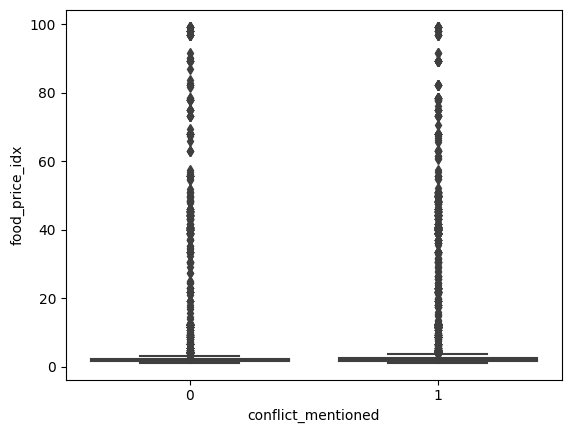

In [19]:
sns.boxplot(x='conflict_mentioned', y='food_price_idx', data=merged_df)
plt.show()

In [20]:

group0 = merged_df[merged_df['conflict_mentioned'] == 0]['food_price_idx']
group1 = merged_df[merged_df['conflict_mentioned'] == 1]['food_price_idx']

t_stat, p_value = ttest_ind(group0, group1)
print(p_value)

4.4241732978833524e-10


## HDBSCAN using Geo location

In [21]:
df_loc = df[['district', 'centx', 'centy']].drop_duplicates(subset=['centx', 'centy'])

In [22]:
df_loc

,district,centx,centy
0,Bor,32.00486,6.465644
56,Fashoda,31.84424,9.980295
55,Ezo,27.89410,5.460567
54,Budi,33.44930,4.357813
53,Yei,30.34454,4.252148
...,...,...,...
23,Aweil North,26.72969,9.334756
22,Pariang,30.11880,9.815146
21,Juba,31.48342,4.717081
20,Koch,29.85742,8.633903


In [23]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

In [24]:

data = df_loc[['centx', 'centy']].values

# Create a distance matrix using haversine distance
distance_matrix = np.array([[haversine_distance(data[i, 1], data[i, 0], data[j, 1], data[j, 0]) 
                            for j in range(len(data))] for i in range(len(data))])

# Apply HDBSCAN clustering with precomputed distance
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=3, min_samples=2) 
# Adjust min_cluster_size based on your requirements
labels = clusterer.fit_predict(distance_matrix)

df_loc['cluster_labels'] = labels

In [25]:
distance_matrix

array([[  0.        , 391.21077954, 468.15082206, ..., 202.81325264,
        337.86904428, 294.67185023],
       [391.21077954,   0.        , 664.76947722, ..., 586.59289954,
        264.46578878, 295.51955161],
       [468.15082206, 664.76947722,   0.        , ..., 406.04288398,
        414.05212405, 370.97871967],
       ...,
       [202.81325264, 586.59289954, 406.04288398, ...,   0.        ,
        471.08585536, 416.21567773],
       [337.86904428, 264.46578878, 414.05212405, ..., 471.08585536,
          0.        ,  57.27476435],
       [294.67185023, 295.51955161, 370.97871967, ..., 416.21567773,
         57.27476435,   0.        ]])

In [26]:
df_loc['cluster_labels'].unique()

array([ 0,  1, -1], dtype=int64)

In [27]:
df_loc[df_loc['cluster_labels']==-1].shape

(5, 4)

In [28]:
df_loc

,district,centx,centy,cluster_labels
0,Bor,32.00486,6.465644,0
56,Fashoda,31.84424,9.980295,0
55,Ezo,27.89410,5.460567,0
54,Budi,33.44930,4.357813,1
53,Yei,30.34454,4.252148,1
...,...,...,...,...
23,Aweil North,26.72969,9.334756,0
22,Pariang,30.11880,9.815146,0
21,Juba,31.48342,4.717081,1
20,Koch,29.85742,8.633903,0


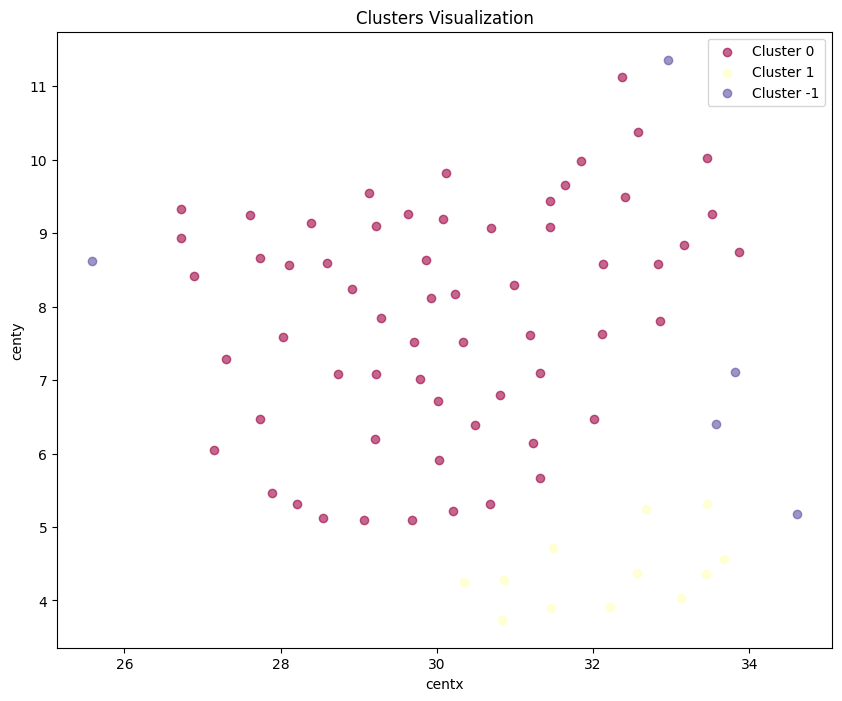

In [29]:
# Your dataframe is named df
plt.figure(figsize=(10, 8))

# Get unique cluster labels
clusters = df_loc['cluster_labels'].unique()

# Assign a unique color to each cluster
colors = plt.cm.Spectral(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    subset = df_loc[df_loc['cluster_labels'] == cluster]
    plt.scatter(subset['centx'], subset['centy'], c=[color], label=f"Cluster {cluster}", alpha=0.6)
    
    # Annotate each point with its district name
    #for _, row in subset.iterrows():
        # Only annotate if the district is in the grouped_loc series
        #if row['district'] in grouped_loc.values:
            #plt.annotate(row['district'], (row['centx'], row['centy']), fontsize=9, alpha=0.75)
    # Annotate each point with its district name
    #for _, row in subset.iterrows():
        #plt.annotate(row['district'], (row['centx'], row['centy']), fontsize=9, alpha=0.75)


plt.xlabel('centx')
plt.ylabel('centy')
plt.legend()
plt.title('Clusters Visualization')
plt.show()

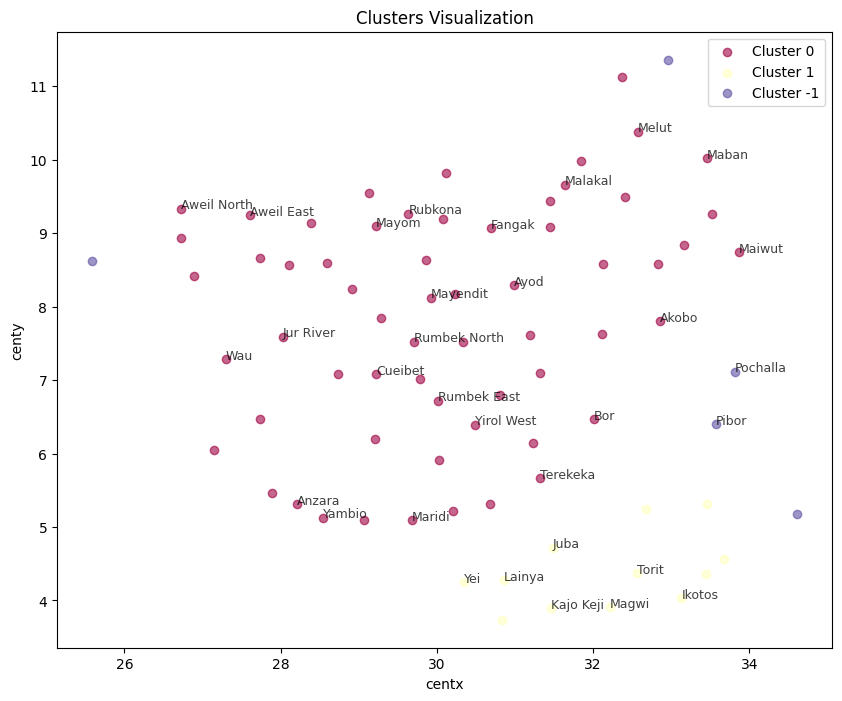

In [30]:
# Your dataframe is named df
plt.figure(figsize=(10, 8))

# Get unique cluster labels
clusters = df_loc['cluster_labels'].unique()

# Assign a unique color to each cluster
colors = plt.cm.Spectral(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    subset = df_loc[df_loc['cluster_labels'] == cluster]
    plt.scatter(subset['centx'], subset['centy'], c=[color], label=f"Cluster {cluster}", alpha=0.6)
    
    # Annotate each point with its district name
    for _, row in subset.iterrows():
        # Only annotate if the district is in the grouped_loc series
        if row['district'] in conflict_loc.values:
            plt.annotate(row['district'], (row['centx'], row['centy']), fontsize=9, alpha=0.75)
    


plt.xlabel('centx')
plt.ylabel('centy')
plt.legend()
plt.title('Clusters Visualization')
plt.show()

In [31]:
df_cluster = df.merge(df_loc, on=['district','centx','centy'], how='inner')

In [32]:
df_cluster

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date,cluster_labels
0,South Sudan,74,Bor,32.00486,6.465644,2007_01,2007,1,2.0,NaN,...,0,0,0.561363,14008.330,7.961984,239344.00,11393.76,90.85030,2007-01-01,0
1,South Sudan,74,Bor,32.00486,6.465644,2007_02,2007,2,2.0,NaN,...,0,0,0.565693,14008.330,7.961984,239344.00,11393.76,90.85030,2007-02-01,0
2,South Sudan,74,Bor,32.00486,6.465644,2007_03,2007,3,2.0,NaN,...,0,0,0.592437,14008.330,7.961984,239344.00,11393.76,90.85030,2007-03-01,0
3,South Sudan,74,Bor,32.00486,6.465644,2007_04,2007,4,2.0,NaN,...,0,0,0.605352,14008.330,7.961984,239344.00,11393.76,90.85030,2007-04-01,0
4,South Sudan,74,Bor,32.00486,6.465644,2007_05,2007,5,2.0,NaN,...,0,0,0.618699,14008.330,7.961984,239344.00,11393.76,90.85030,2007-05-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12319,South Sudan,122,Mayendit,29.91969,8.122516,2019_10,2019,10,3.0,1.0,...,1,1,75.005490,3074.016,16.020520,72191.00,11890.89,85.85294,2019-10-01,0
12320,South Sudan,122,Mayendit,29.91969,8.122516,2019_11,2019,11,3.0,NaN,...,0,0,78.239550,3074.016,16.020520,72191.00,11890.89,85.85294,2019-11-01,0
12321,South Sudan,122,Mayendit,29.91969,8.122516,2019_12,2019,12,3.0,NaN,...,0,0,82.409040,3074.016,16.020520,72191.00,11890.89,85.85294,2019-12-01,0
12322,South Sudan,122,Mayendit,29.91969,8.122516,2020_01,2020,1,3.0,NaN,...,0,0,80.841690,3074.016,16.020520,75483.42,11890.89,85.85294,2020-01-01,0


In [33]:
df_cluster.sort_values(by=['district', 'year', 'month'])

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date,cluster_labels
10744,South Sudan,136,Abiemnhom,29.13019,9.550939,2007_01,2007,1,2.0,NaN,...,0,0,0.600941,2408.233,1.742261,18973.21,11004.64,91.48276,2007-01-01,0
10745,South Sudan,136,Abiemnhom,29.13019,9.550939,2007_02,2007,2,2.0,NaN,...,0,0,0.584477,2408.233,1.742261,18973.21,11004.64,91.48276,2007-02-01,0
10746,South Sudan,136,Abiemnhom,29.13019,9.550939,2007_03,2007,3,2.0,NaN,...,0,0,0.597499,2408.233,1.742261,18973.21,11004.64,91.48276,2007-03-01,0
10747,South Sudan,136,Abiemnhom,29.13019,9.550939,2007_04,2007,4,2.0,NaN,...,0,0,0.619426,2408.233,1.742261,18973.21,11004.64,91.48276,2007-04-01,0
10748,South Sudan,136,Abiemnhom,29.13019,9.550939,2007_05,2007,5,2.0,NaN,...,0,0,0.645193,2408.233,1.742261,18973.21,11004.64,91.48276,2007-05-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6315,South Sudan,101,Yirol West,30.48698,6.395244,2019_10,2019,10,3.0,1.0,...,2,3,88.886650,4879.717,0.462767,154856.00,25073.43,87.71930,2019-10-01,0
6316,South Sudan,101,Yirol West,30.48698,6.395244,2019_11,2019,11,3.0,NaN,...,0,0,93.556460,4879.717,0.462767,154856.00,25073.43,87.71930,2019-11-01,0
6317,South Sudan,101,Yirol West,30.48698,6.395244,2019_12,2019,12,3.0,NaN,...,2,1,98.434210,4879.717,0.462767,154856.00,25073.43,87.71930,2019-12-01,0
6318,South Sudan,101,Yirol West,30.48698,6.395244,2020_01,2020,1,3.0,NaN,...,3,0,98.732880,4879.717,0.462767,111980.60,25073.43,87.71930,2020-01-01,0


## Group by population


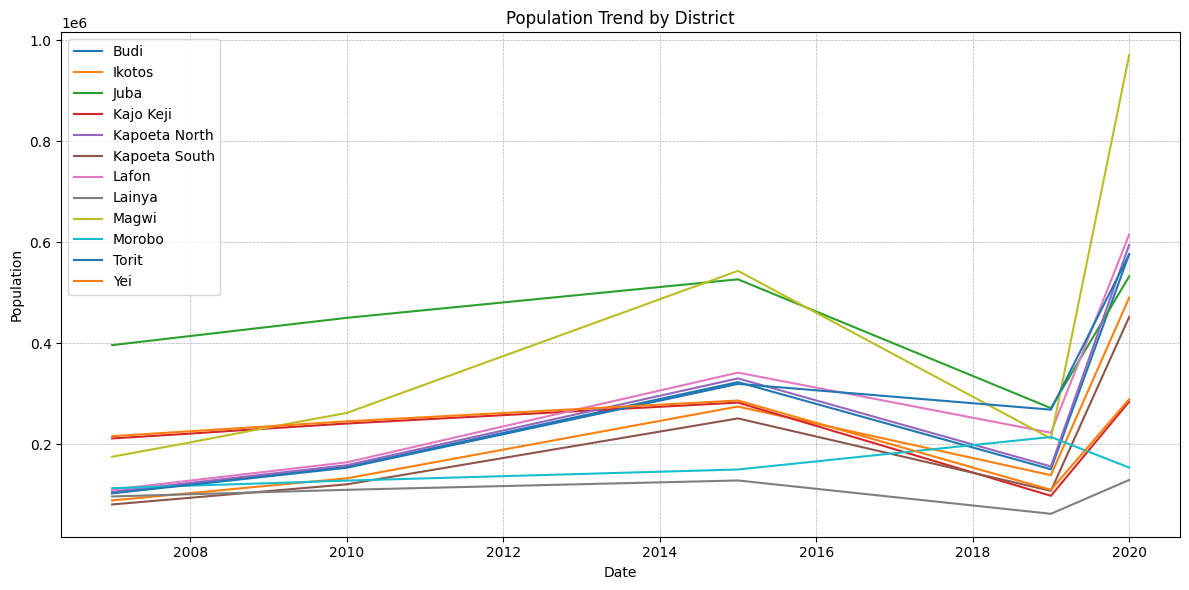

In [34]:
df_cluster0 = df_cluster[df_cluster['cluster_labels']==0]
df_cluster1 = df_cluster[df_cluster['cluster_labels']==1]

plt.figure(figsize=(12, 6))

# Loop through each district and plot their population trend
for district, group in df_cluster1.groupby('district'):
    plt.plot(group['year'], group['pop'], label=district)

plt.title('Population Trend by District')
plt.xlabel('Date')
plt.ylabel('Population')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [35]:

def group_by_monthly_pop(df_pop):

    # Sort the data by district, year, month, and cluster
    df_sort = df_pop.sort_values(by=['district', 'year', 'month', 'cluster_labels'])

    # For each cluster and month-year, calculate Q1, Q3, and then group by IQR
    def bin_using_iqr(sub_df):
        if sub_df['cluster_labels'].iloc[0] == -1:
            sub_df['Population_Group'] = -1
            return sub_df

        Q1 = sub_df['pop'].quantile(0.25)
        Q3 = sub_df['pop'].quantile(0.75)
        conditions = [
            sub_df['pop'] < Q1,
            (sub_df['pop'] >= Q1) & (sub_df['pop'] <= Q3),
            sub_df['pop'] > Q3
        ]

        # Adjusting the labels based on the cluster
        cluster_offset = 3 * sub_df['cluster_labels'].iloc[0]  # Gives 0 for cluster 0, and 3 for cluster 1
        labels = [1 + cluster_offset, 2 + cluster_offset, 3 + cluster_offset]  # Numeric labels adjusted for each cluster
        sub_df['Population_Group'] = np.select(conditions, labels, default=-1)
        return sub_df

    df_grouped = df_sort.groupby(['cluster_labels', 'year', 'month']).apply(bin_using_iqr).reset_index(drop=True)
    
    return df_grouped


- The population groups for cluster 0 will be 1 (Low), 2 (Medium), and 3 (High). For cluster 1, they will be 4 (Low), 5 (Medium), and 6 (High). And for cluster -1, the population group will be -1.

In [37]:
result = group_by_monthly_pop(df_cluster)

In [38]:
result.sort_values(by=['year','month'])

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date,cluster_labels,Population_Group
0,South Sudan,136,Abiemnhom,29.13019,9.550939,2007_01,2007,1,2.0,NaN,...,0,0.600941,2408.233,1.742261,18973.21,11004.640,91.48276,2007-01-01,0,1
158,South Sudan,114,Akobo,32.85308,7.799214,2007_01,2007,1,4.0,NaN,...,0,0.616429,9027.626,10.046920,147537.90,2787.772,89.71963,2007-01-01,0,3
316,South Sudan,86,Anzara,28.20598,5.309739,2007_01,2007,1,1.0,NaN,...,0,0.567126,6541.319,18.819290,71208.90,51381.880,58.21333,2007-01-01,0,2
474,South Sudan,128,Aweil Center,26.89562,8.417934,2007_01,2007,1,2.0,NaN,...,0,0.606129,11202.960,0.173833,48640.05,3754.860,81.76336,2007-01-01,0,1
632,South Sudan,141,Aweil East,27.61364,9.243139,2007_01,2007,1,3.0,NaN,...,0,0.597833,6400.981,26.804220,347359.50,3544.279,90.16216,2007-01-01,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11691,South Sudan,105,Wulu,29.20889,6.200243,2020_02,2020,2,2.0,0.0,...,1,83.059000,11894.780,0.032678,45158.50,40366.550,65.10490,2020-02-01,0,1
11849,South Sudan,82,Yambio,28.54729,5.124909,2020_02,2020,2,3.0,0.0,...,0,78.067220,8896.165,19.126490,197278.90,60628.160,60.88350,2020-02-01,0,3
12007,South Sudan,81,Yei,30.34454,4.252148,2020_02,2020,2,3.0,0.0,...,0,91.476050,6713.251,16.303490,288875.40,75813.310,62.85185,2020-02-01,1,5
12165,South Sudan,107,Yirol East,30.80245,6.793194,2020_02,2020,2,4.0,0.0,...,5,101.640400,5599.893,2.482445,73693.13,18421.020,91.75000,2020-02-01,0,2


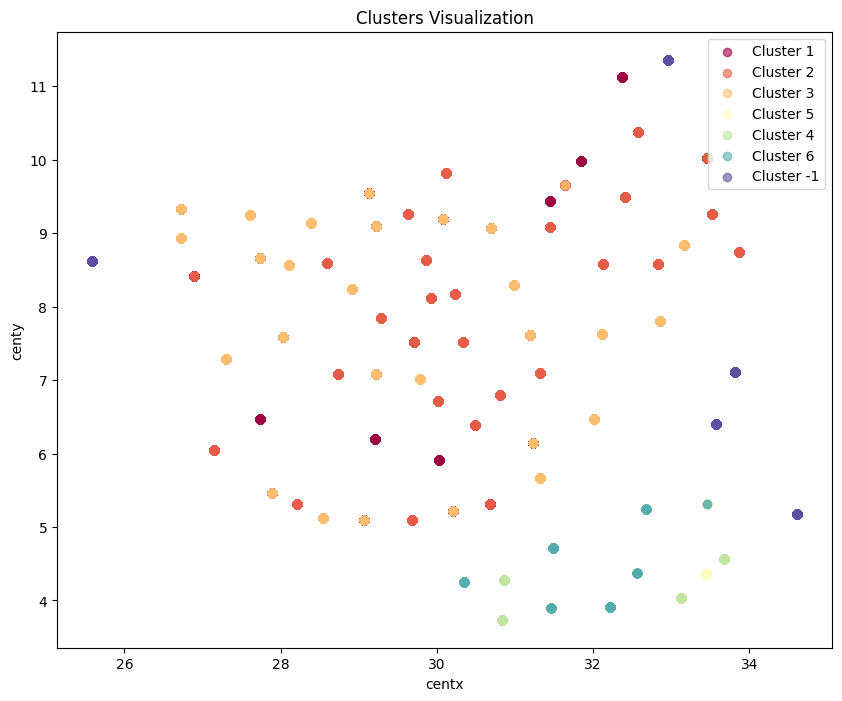

In [39]:

plt.figure(figsize=(10, 8))

# Get unique cluster labels
clusters = result['Population_Group'].unique()

# Assign a unique color to each cluster
colors = plt.cm.Spectral(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    subset = result[result['Population_Group'] == cluster]
    plt.scatter(subset['centx'], subset['centy'], c=[color], label=f"Cluster {cluster}", alpha=0.6)
    
    # Annotate each point with its district name
    #for _, row in subset.iterrows():
        # Only annotate if the district is in the grouped_loc series
        #if row['district'] in grouped_loc.values:
            #plt.annotate(row['district'], (row['centx'], row['centy']), fontsize=9, alpha=0.75)
    # Annotate each point with its district name
    #for _, row in subset.iterrows():
        #plt.annotate(row['district'], (row['centx'], row['centy']), fontsize=9, alpha=0.75)


plt.xlabel('centx')
plt.ylabel('centy')
plt.legend()
plt.title('Clusters Visualization')
plt.show()
        

## Group by food_price_idx

In [40]:
def group_by_monthly_food_price_idx(df_food):
    
    # Sort the data by district, year, month, and cluster
    df_sort = df_food.sort_values(by=['district', 'year', 'month', 'cluster_labels'])


    # For each month-year, calculate Q1, Q3, and then group by IQR
    def bin_using_iqr(sub_df):
        if sub_df['cluster_labels'].iloc[0] == -1:
            sub_df['Price_Group'] = -1
            return sub_df
        
        Q1 = sub_df['food_price_idx'].quantile(0.25)
        Q3 = sub_df['food_price_idx'].quantile(0.75)
        conditions = [
            sub_df['food_price_idx'] < Q1,
            (sub_df['food_price_idx'] >= Q1) & (sub_df['food_price_idx'] <= Q3),
            sub_df['food_price_idx'] > Q3
        ]
        
        # Adjusting the labels based on the cluster
        cluster_offset = 3 * sub_df['cluster_labels'].iloc[0]  # Gives 0 for cluster 0, and 3 for cluster 1
        labels = [1 + cluster_offset, 2 + cluster_offset, 3 + cluster_offset]  # Numeric labels adjusted for each cluster
        
        sub_df['Price_Group'] = np.select(conditions, labels, default=-1)
        return sub_df

    df_grouped = df_sort.groupby(['cluster_labels', 'year', 'month']).apply(bin_using_iqr).reset_index(drop=True)
    
    return df_grouped


In [41]:
result_final = group_by_monthly_food_price_idx(result)

In [42]:
result_final.sort_values(by=['year','month'])

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date,cluster_labels,Population_Group,Price_Group
0,South Sudan,136,Abiemnhom,29.13019,9.550939,2007_01,2007,1,2.0,NaN,...,0.600941,2408.233,1.742261,18973.21,11004.640,91.48276,2007-01-01,0,1,2
158,South Sudan,114,Akobo,32.85308,7.799214,2007_01,2007,1,4.0,NaN,...,0.616429,9027.626,10.046920,147537.90,2787.772,89.71963,2007-01-01,0,3,2
316,South Sudan,86,Anzara,28.20598,5.309739,2007_01,2007,1,1.0,NaN,...,0.567126,6541.319,18.819290,71208.90,51381.880,58.21333,2007-01-01,0,2,1
474,South Sudan,128,Aweil Center,26.89562,8.417934,2007_01,2007,1,2.0,NaN,...,0.606129,11202.960,0.173833,48640.05,3754.860,81.76336,2007-01-01,0,1,2
632,South Sudan,141,Aweil East,27.61364,9.243139,2007_01,2007,1,3.0,NaN,...,0.597833,6400.981,26.804220,347359.50,3544.279,90.16216,2007-01-01,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11691,South Sudan,105,Wulu,29.20889,6.200243,2020_02,2020,2,2.0,0.0,...,83.059000,11894.780,0.032678,45158.50,40366.550,65.10490,2020-02-01,0,1,2
11849,South Sudan,82,Yambio,28.54729,5.124909,2020_02,2020,2,3.0,0.0,...,78.067220,8896.165,19.126490,197278.90,60628.160,60.88350,2020-02-01,0,3,1
12007,South Sudan,81,Yei,30.34454,4.252148,2020_02,2020,2,3.0,0.0,...,91.476050,6713.251,16.303490,288875.40,75813.310,62.85185,2020-02-01,1,5,6
12165,South Sudan,107,Yirol East,30.80245,6.793194,2020_02,2020,2,4.0,0.0,...,101.640400,5599.893,2.482445,73693.13,18421.020,91.75000,2020-02-01,0,2,3


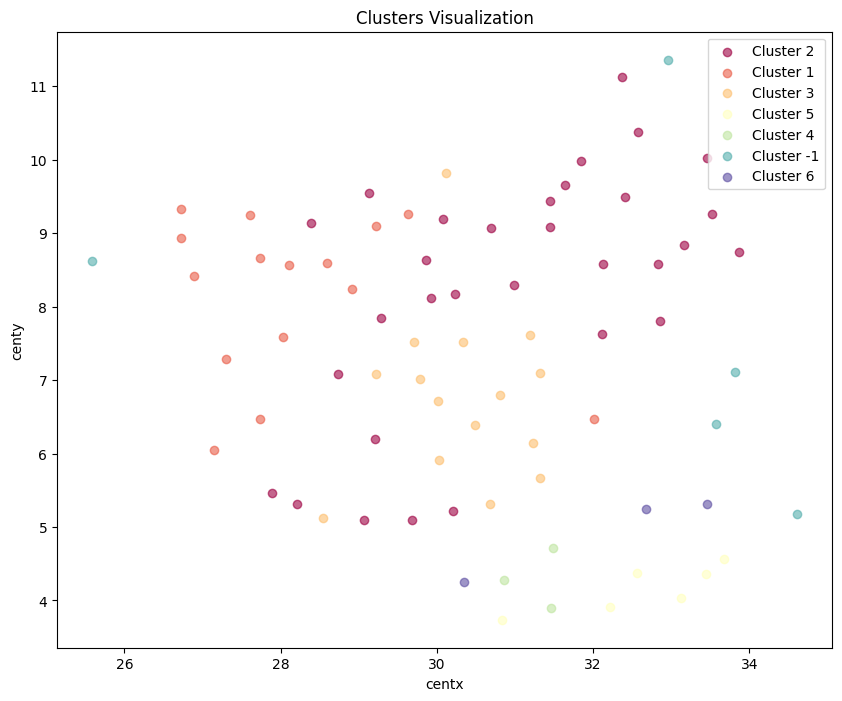

In [45]:
plt.figure(figsize=(10, 8))

# Get unique cluster labels
result_date = result_final[(result_final['year']==2013)&(result_final['month']==8)]
clusters = result_date['Price_Group'].unique()

# Assign a unique color to each cluster
colors = plt.cm.Spectral(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    subset = result_date[result_date['Price_Group'] == cluster]
    plt.scatter(subset['centx'], subset['centy'], c=[color], label=f"Cluster {cluster}", alpha=0.6)
    
    # Annotate each point with its district name
    #for _, row in subset.iterrows():
        # Only annotate if the district is in the grouped_loc series
        #if row['district'] in grouped_loc.values:
            #plt.annotate(row['district'], (row['centx'], row['centy']), fontsize=9, alpha=0.75)
    # Annotate each point with its district name
    #for _, row in subset.iterrows():
        #plt.annotate(row['district'], (row['centx'], row['centy']), fontsize=9, alpha=0.75)


plt.xlabel('centx')
plt.ylabel('centy')
plt.legend()
plt.title('Clusters Visualization')
plt.show()
        

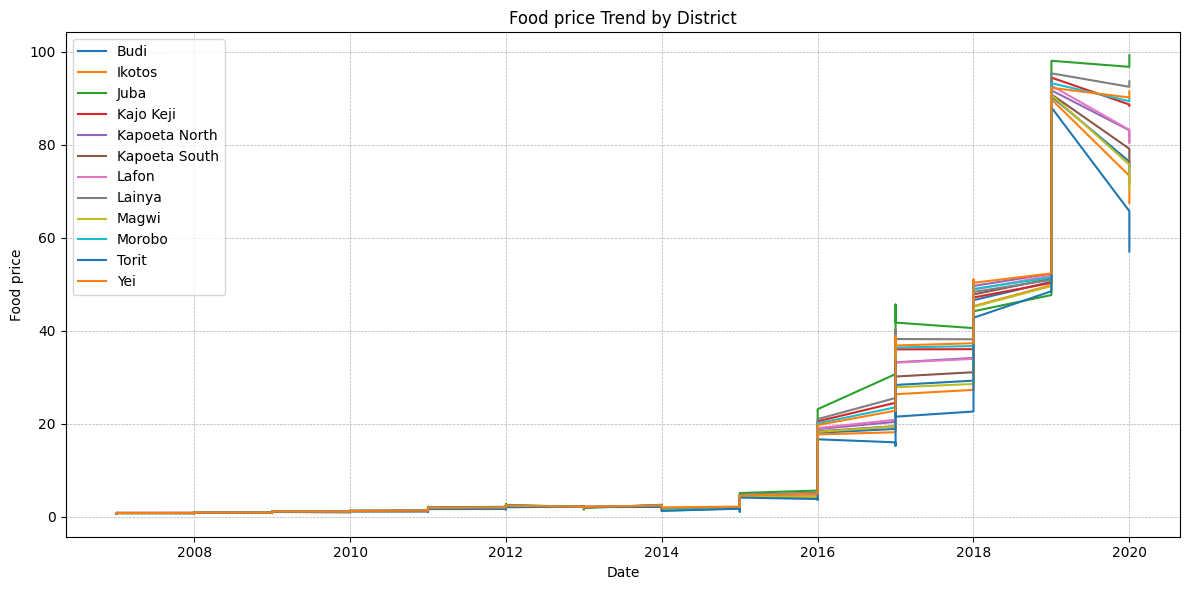

In [89]:
df_cluster0 = df_cluster[df_cluster['cluster_labels']==0]
df_cluster1 = df_cluster[df_cluster['cluster_labels']==1]

plt.figure(figsize=(12, 6))

# Loop through each district and plot their population trend
for district, group in df_cluster1.groupby('district'):
    plt.plot(group['year'], group['food_price_idx'], label=district)

plt.title('Food price Trend by District')
plt.xlabel('Date')
plt.ylabel('Food price')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [46]:
# Export the final results to csv.file
result_final.to_csv('Xiaoya_group_results.csv', index=False)

## Read topics file

In [123]:
group_summary = pd.read_csv("data/grouped_articles_summary.csv")
topics_summary = pd.read_csv("data/articles_topics_final.csv").drop(columns=['Unnamed: 0'])

In [124]:
topics_summary['date'] = pd.to_datetime(topics_summary['date'], format='%m/%d/%Y').dt.strftime('%Y_%m')

In [125]:
group_summary = group_summary.sort_values(by=['date','location_new']).reset_index(drop=True)
topics_summary = topics_summary.sort_values(by=['date','location_new']).reset_index(drop=True)

In [126]:
topics_summary

,summary,date,location_article,lat,lng,location_new,category
0,The article discusses Sudanese President Al-Ba...,2011_06,Beijing,39.904211,116.407395,Beijing,not provided
1,The article discusses a Southern Sudanese rese...,2011_06,Gogrial,8.532399,28.099100,Gogrial West,not provided
2,The article discusses the Governor of Lakes St...,2011_06,Juba,4.859363,31.571250,Juba,economics
3,The article discusses the debate in South Suda...,2011_06,Juba,4.859363,31.571250,Juba,not provided
4,The article discusses a critical response by I...,2011_06,Juba,4.859363,31.571250,Juba,not provided
...,...,...,...,...,...,...,...
18515,The article discusses the establishment of a m...,2023_04,North Darfur State,15.766197,24.904221,North Darfur State,conflict
18516,The article discusses the renewal of the manda...,2023_04,South Sudan,6.876992,31.306979,South Sudan,humanitarian
18517,The article discusses the recovery of Presiden...,2023_04,Torongo,0.129138,35.620484,Torongo,not provided
18518,The article discusses a UN report on the perva...,2023_04,Unity State,8.927721,29.788925,Unity State,conflict


In [117]:
conflict_crisis = [
    'conflict',
    'refugees',
    'conflict, humanitarian',
    'hunger, refugees, conflict, humanitarian',
    'conflict, hunger, refugees, humanitarian',
    'conflict, refugees, humanitarian, hunger',
    'conflict, refugees',
    'conflict, humanitarian, hunger',
    'conflict, humanitarian, refugees',
    'conflict, hunger',
    'conflict, hunger, refugees, humanitarian, agriculture',
    'border dispute',
    'border conflict',
    'conflict, natural disaster',
    'water, conflict',
    'conflict, poverty, corruption, humanitarian, hunger'
]

peace_diplomacy = [
    'peacekeeping',
    'peace',
    'peace and security',
    'peace process',
    'peace negotiations',
    'peace agreement',
    'peace deal',
    'peace, stability',
    'peace diplomacy'
]

human_rights_social_issues = [
    'humanitarian',
    'gender equality',
    'human rights abuses',
    'human rights',
    'women empowerment',
    'child labour',
    'gender-based violence',
    'gender inequality',
    'identity',
    'discrimination',
    'human trafficking',
    'disabilities'
]

government_politics_governance = [
    'not provided',
    'corruption',
    'politics',
    'diplomacy',
    'government',
    'protests',
    'freedom of information',
    'freedom of expression',
    'foreign affairs',
    'border issues'
]

environment_natural_resources = [
    'natural disaster',
    'climate change',
    'water scarcity',
    'environment',
    'environmental',
    'water management',
    'water resources',
    'water',
    'wildlife conservation',
    'environmental disaster'
]

culture_identity = [
    'religion',
    'arts and culture',
    'culture',
    'cultural diversity',
    'hunting',
    'art and culture'
]

economic_development = [
    'agriculture',
    'economics',
    'infrastructure',
    'rural development',
    'development',
    'international cooperation'
]

health_nutrition = [
    'hunger',
    'health',
    'nutrition',
    'HIV/AIDS'
]

media_communication = [
    'media',
    'freedom of press',
    'sports'
]

labor_work_conditions = [
    'crime',
    'child labor',
    'hazardous working conditions'
]


In [60]:
category_mapping = {}
for broad_category, sublist in [
    ('conflict_crisis', conflict_crisis),
    ('peace_diplomacy', peace_diplomacy),
    ('human_rights_social_issues', human_rights_social_issues),
    ('government_politics_governance', government_politics_governance),
    ('environment_natural_resources', environment_natural_resources),
    ('culture_identity', culture_identity),
    ('economic_development', economic_development),
    ('health_nutrition', health_nutrition),
    ('media_communication', media_communication),
    ('labor_work_conditions', labor_work_conditions)
]:
    for small_category in sublist:
        category_mapping[small_category] = broad_category
        
# Explicitly map "not provided" to itself
category_mapping['not provided'] = 'not provided'

# Apply mapping to 'category' column in dataframe
group_summary['category'] = group_summary['category'].map(lambda x: category_mapping.get(x, x))
topics_summary['category'] = topics_summary['category'].map(lambda x: category_mapping.get(x,x))

In [106]:
group_summary

,summary,date,location_new,category
36833,The article discusses the decision of Western ...,2011_06,Anzara,agriculture
40094,The article discusses Sudanese President Al-Ba...,2011_06,Beijing,not provided
36834,The article discusses the decision of Western ...,2011_06,Ezo,agriculture
40092,The article discusses a Southern Sudanese rese...,2011_06,Gogrial West,not provided
36831,The article discusses the decision of Western ...,2011_06,Ibba,agriculture
...,...,...,...,...
52566,The article discusses the establishment of a m...,2023_04,North Darfur State,conflict
52525,The article discusses the renewal of the manda...,2023_04,South Sudan,humanitarian
52547,The article discusses the recovery of Presiden...,2023_04,Torongo,not provided
52497,The article discusses a UN report on the perva...,2023_04,Unity State,conflict


In [68]:
topics_summary = topics_summary.drop(columns=['index'])

In [70]:
# export topics summary to csv file
topics_summary.to_csv('topics_summary_results.csv', index=False)


In [127]:
group_summary.to_csv('topics_group_summary_results.csv', index=False)

In [128]:
topics_summary

,summary,date,location_article,lat,lng,location_new,category
0,The article discusses Sudanese President Al-Ba...,2011_06,Beijing,39.904211,116.407395,Beijing,not provided
1,The article discusses a Southern Sudanese rese...,2011_06,Gogrial,8.532399,28.099100,Gogrial West,not provided
2,The article discusses the Governor of Lakes St...,2011_06,Juba,4.859363,31.571250,Juba,economics
3,The article discusses the debate in South Suda...,2011_06,Juba,4.859363,31.571250,Juba,not provided
4,The article discusses a critical response by I...,2011_06,Juba,4.859363,31.571250,Juba,not provided
...,...,...,...,...,...,...,...
18515,The article discusses the establishment of a m...,2023_04,North Darfur State,15.766197,24.904221,North Darfur State,conflict
18516,The article discusses the renewal of the manda...,2023_04,South Sudan,6.876992,31.306979,South Sudan,humanitarian
18517,The article discusses the recovery of Presiden...,2023_04,Torongo,0.129138,35.620484,Torongo,not provided
18518,The article discusses a UN report on the perva...,2023_04,Unity State,8.927721,29.788925,Unity State,conflict


### Create news topics columns and match the news articles to each district

In [103]:
# Extract rows from the news data that have specified topics (st).
topics_summary_st = topics_summary[topics_summary['category']!= 'not provided']
group_summary_st = group_summary[group_summary['category']!= 'not provided']
